# Date Parts
Simple illustration extracting date parts and cyclically encoding months.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

print('Packages loaded.')

Packages loaded.


## Load `Daily 10-Year Treasury Yields`

In [2]:
df = pd.read_csv('data/dgs10.csv')
df.head()

,DATE,DGS10
0,1962-01-02,4.06
1,1962-01-03,4.03
2,1962-01-04,3.99
3,1962-01-05,4.02
4,1962-01-08,4.03


In [3]:
print(f'Records: {df.shape[0]:,}')
print(f'First observation: {df.DATE[0]}')
print(f'Last observation: {df.iloc[-1, 0]}')

Records: 15,623
First observation: 1962-01-02
Last observation: 2021-11-18


### Extract `Date Parts` from the `DATE` field
By extracting the date components (e.g., year, month, day, day of the week) you can add those features into models as dummies or leverage those fields for visualization and exploratory analysis.

In [4]:
df['DATE'] = pd.to_datetime(df.DATE)
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day
df['DOTW'] = df['DATE'].dt.weekday
df['DAYNAME'] = df['DATE'].dt.day_name()

df.head()

,DATE,DGS10,YEAR,MONTH,DAY,DOTW,DAYNAME
0,1962-01-02,4.06,1962,1,2,1,Tuesday
1,1962-01-03,4.03,1962,1,3,2,Wednesday
2,1962-01-04,3.99,1962,1,4,3,Thursday
3,1962-01-05,4.02,1962,1,5,4,Friday
4,1962-01-08,4.03,1962,1,8,0,Monday


In [5]:
df = df.set_index('DATE')
df.head()

,DGS10,YEAR,MONTH,DAY,DOTW,DAYNAME
DATE,,,,,,
1962-01-02,4.06,1962,1,2,1,Tuesday
1962-01-03,4.03,1962,1,3,2,Wednesday
1962-01-04,3.99,1962,1,4,3,Thursday
1962-01-05,4.02,1962,1,5,4,Friday
1962-01-08,4.03,1962,1,8,0,Monday


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15623 entries, 1962-01-02 to 2021-11-18
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DGS10    15623 non-null  object
 1   YEAR     15623 non-null  int64 
 2   MONTH    15623 non-null  int64 
 3   DAY      15623 non-null  int64 
 4   DOTW     15623 non-null  int64 
 5   DAYNAME  15623 non-null  object
dtypes: int64(4), object(2)
memory usage: 854.4+ KB


In [7]:
df['DGS10'].str[0].value_counts().sort_index()

.     666
0     207
1    2423
2    1582
3    1205
4    2340
5    1690
6    1867
7    1940
8    1223
9     480
Name: DGS10, dtype: int64

In [8]:
excluded_values = ['.']

df = df.query('DGS10 != @excluded_values')
df['INT10'] = pd.to_numeric(df['DGS10'])
df.head()

,DGS10,YEAR,MONTH,DAY,DOTW,DAYNAME,INT10
DATE,,,,,,,
1962-01-02,4.06,1962,1,2,1,Tuesday,4.06
1962-01-03,4.03,1962,1,3,2,Wednesday,4.03
1962-01-04,3.99,1962,1,4,3,Thursday,3.99
1962-01-05,4.02,1962,1,5,4,Friday,4.02
1962-01-08,4.03,1962,1,8,0,Monday,4.03


### Plot the `timeseries`

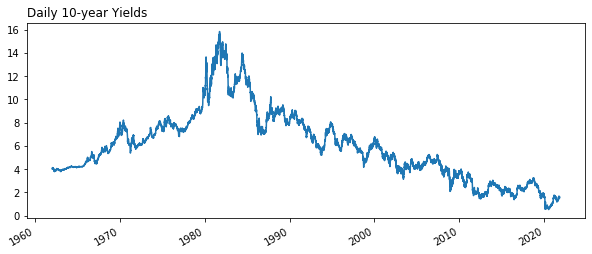

In [9]:
df['INT10'].plot(figsize=(10,4))
plt.title('Daily 10-year Yields', loc='left')
plt.xlabel('')
plt.show()

### Monthly Average

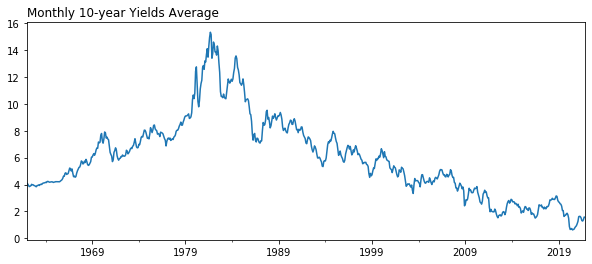

In [10]:
df['INT10'].resample('M').mean().plot(figsize=(10,4))
plt.title('Monthly 10-year Yields Average', loc='left')
plt.xlabel('')
plt.show()

### Seasonal changes?

In [11]:
df['INT10_L1'] = df['INT10'].shift(1)
df['DAILY_CHG'] = (df['INT10'] - df['INT10_L1'])*100
df.head()

,DGS10,YEAR,MONTH,DAY,DOTW,DAYNAME,INT10,INT10_L1,DAILY_CHG
DATE,,,,,,,,,
1962-01-02,4.06,1962,1,2,1,Tuesday,4.06,NaN,NaN
1962-01-03,4.03,1962,1,3,2,Wednesday,4.03,4.06,-3.0
1962-01-04,3.99,1962,1,4,3,Thursday,3.99,4.03,-4.0
1962-01-05,4.02,1962,1,5,4,Friday,4.02,3.99,3.0
1962-01-08,4.03,1962,1,8,0,Monday,4.03,4.02,1.0


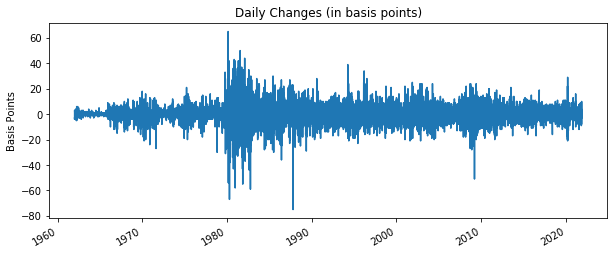

In [12]:
df['DAILY_CHG'].plot(figsize=(10,4))
plt.title('Daily Changes (in basis points)')
plt.xlabel('')
plt.ylabel('Basis Points')
plt.show()

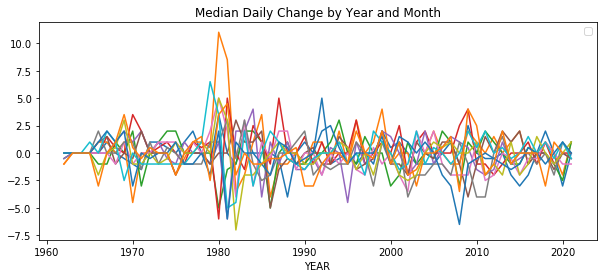

In [13]:
df.pivot_table(index='YEAR', 
               columns='MONTH', 
               values='DAILY_CHG', 
               aggfunc='median').plot(figsize=(10,4))
plt.legend('')
plt.title('Median Daily Change by Year and Month')
plt.show()

> No noticable seasonality at the monthly level.

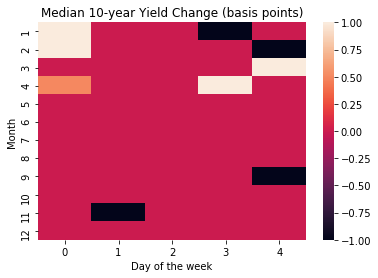

In [14]:
monthly_dotw = df.pivot_table(index='MONTH', 
               columns='DOTW', 
               values='DAILY_CHG', 
               aggfunc='median'
              )

sns.heatmap(monthly_dotw)
plt.title('Median 10-year Yield Change (basis points)')
plt.xlabel('Day of the week')
plt.ylabel('Month')
plt.show()

> Doesn't look like there is much of a pattern.

# No evidence of seasonality.
This is good, otherwise the markets would have predictable inefficiencies.

### Minor Issue with dates
How could we show January is closer to December than October to December?

January = 1  
December = 12  
December - January = 11? So January is 11 months away?

In [15]:
MONTH_NORM = 2 * np.pi * df['MONTH'] / df['MONTH'].max()
MONTH_COSINE = np.cos(MONTH_NORM)
MONTH_SIN = np.sin(MONTH_NORM)

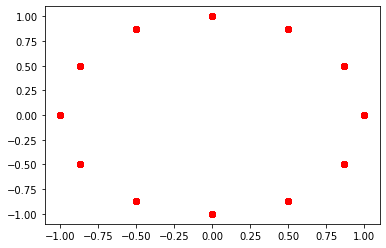

In [16]:
plt.plot(MONTH_SIN, MONTH_COSINE,'ro')
plt.show()

> Now the January could be considered closer to December than October to December.

### Pros
- Cyclically encoded the months so its more representative of the continuous calendar system.  

### Cons
- Two features instead of one.  
- Some models (e.g., trees) look at one feature at a time.  